In [ ]:
import pickle
import numpy as np
import cv2
from collections import defaultdict
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, transforms, models

import torch.optim as optim
from torch.optim import lr_scheduler
import time
from tqdm.notebook import tqdm

%matplotlib inline

In [ ]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [ ]:
#  we will verify that GPU is enabled for this notebook
DEVICE = torch.device("cpu")

if torch.cuda.is_available():
    print('CUDA is available! Training on GPU...')
    DEVICE = torch.device("cuda")
    # Clear GPU memory
    torch.cuda.empty_cache()
else:
    print('CUDA is not available. Training on CPU...')

CUDA is available! Training on GPU...


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu Nov 16 19:03:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    13W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
!ls train

simpsons_dataset


ToTensor converts a PIL Image with parameters in the range [0, 255] (like all pixels) into a FloatTensor of size (C x H x W) [0,1], then scaling is performed: $input = \frac{input - \mu}{\text{standard deviation}} $, the constants are the means and variances by channels based on ImageNet.

It is also worth noting that we override the getitem method for convenience in working with this data structure. The LabelEncoder is also used to convert string class labels to ids and vice versa. In the dataset description, it is mentioned that the images are of different sizes, as they were taken directly from videos, so we need to resize them to a uniform size (this is done by the _prepare_sample method).

In [ ]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224


class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
         ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
print(len(train_val_files))
print(len(test_files))

20933
991


In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
data = pd.Series(train_val_labels).value_counts().sort_values().to_frame("count")
data

,count
lionel_hutz,3
troy_mcclure,8
disco_stu,8
miss_hoover,17
gil,27
fat_tony,27
otto_mann,32
sideshow_mel,40
agnes_skinner,42
rainier_wolfcastle,45


The dataset is imbalanced.

When dealing with imbalanced datasets, where certain classes have significantly fewer samples than others, training a machine learning model can become challenging. The class with more samples tends to dominate the learning process, leading to a model that might not perform well on the minority class.

To address this issue, the WeightedRandomSampler is often used in PyTorch. It allows you to assign different weights to each sample, influencing the probability of a sample being chosen during training. The idea is to give higher weights to underrepresented classes, ensuring that the model sees these samples more frequently and learns better from them.

Data augmentation.
I borrowed the idea from [this notebook](https://www.kaggle.com/code/wervlad/baseline-2fc-augmentations/notebook)

In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
BATCH_SIZE = 64 # 128
class_count = Counter(train_dataset.labels)
# print(class_count)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, label in enumerate(tqdm(train_dataset.labels)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

N = max(class_count.values()) * len(class_count)  # fit to max
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=2)

  0%|          | 0/15699 [00:00<?, ?it/s]

In [ ]:
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
# uncomment to check it is balanced now
# count = Counter()
# for data, labels in tqdm(train_loader):
#     count += Counter(labels.tolist())
# print(sum(count.values()), count)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

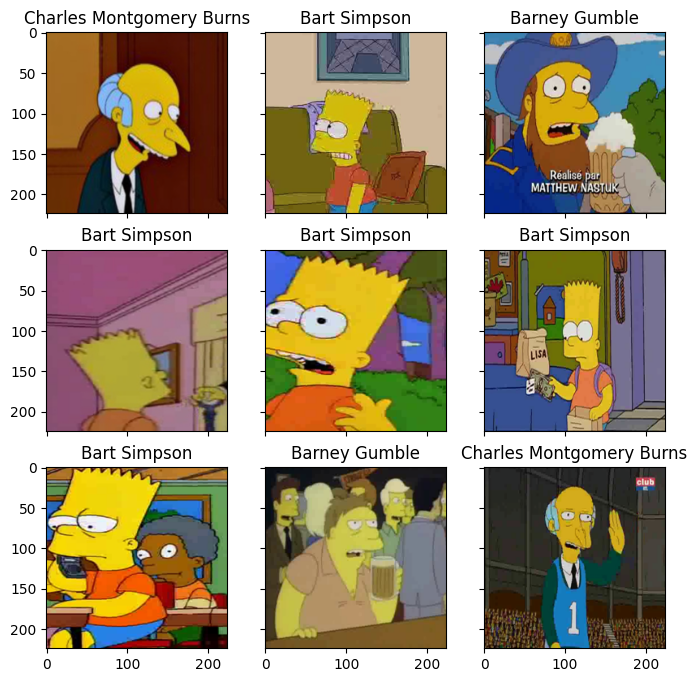

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)


In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(model, criterion, optimizer, scheduler, epochs):
    since = time.time()

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))\

    return history


In [ ]:
n_classes = len(np.unique(train_val_labels))

Transfer learning

In [ ]:
model3 = models.resnet50(pretrained=True)
# uncomment to check it
# print(f"Model: {model3}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 104MB/s]


In [ ]:
model3.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
model3.fc = nn.Linear(model3.fc.in_features, n_classes)
# uncomment to check it
# print(f"Model: {model3}")

In [ ]:
# uncomment to check it
# for param in model3.parameters():
#     print(param.requires_grad)



In [ ]:
for param in model3.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the last convolutional layer (layer4)
for param in model3.layer4.parameters():
    param.requires_grad = True

# Unfreeze the parameters of the classifier (fully connected layers)
for param in model3.fc.parameters():
    param.requires_grad = True

In [ ]:
for param in model3.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
model3 = model3.to(DEVICE)

In [ ]:
currrent_model = model3

In [ ]:
loss_fn = nn.CrossEntropyLoss()

parameters_to_optimize = list(model3.layer4.parameters()) + list(model3.fc.parameters())
optimizer = optim.Adam(parameters_to_optimize, lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
history = train(currrent_model, loss_fn, optimizer, exp_lr_scheduler, epochs=10)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.1775643987619689

Epoch 001 train_loss: 0.1776     val_loss 0.2859 train_acc 0.9541 val_acc 0.9333
loss 0.16904372438880746

Epoch 002 train_loss: 0.1690     val_loss 0.2826 train_acc 0.9575 val_acc 0.9469
loss 0.051339902037638135

Epoch 003 train_loss: 0.0513     val_loss 0.2555 train_acc 0.9873 val_acc 0.9417
loss 0.02901892444579538

Epoch 004 train_loss: 0.0290     val_loss 0.3902 train_acc 0.9933 val_acc 0.9240
loss 0.041497886858252384

Epoch 005 train_loss: 0.0415     val_loss 0.2380 train_acc 0.9911 val_acc 0.9536
loss 0.017235511791094792

Epoch 006 train_loss: 0.0172     val_loss 0.3747 train_acc 0.9963 val_acc 0.9199
loss 0.0216622872641679

Epoch 007 train_loss: 0.0217     val_loss 0.3522 train_acc 0.9953 val_acc 0.9423
loss 0.012986674928549583

Epoch 008 train_loss: 0.0130     val_loss 0.2699 train_acc 0.9970 val_acc 0.9412
loss 0.022922509356421764

Epoch 009 train_loss: 0.0229     val_loss 0.2800 train_acc 0.9956 val_acc 0.9440
loss 0.016036009420939516

Epoch 0

In [ ]:
torch.save(currrent_model.state_dict(), '/content/gdrive/MyDrive/current_model_fine_tune.pth')

In [ ]:
currrent_model.load_state_dict(torch.load('/content/gdrive/MyDrive/current_model_fine_tune.pth'))

<All keys matched successfully>

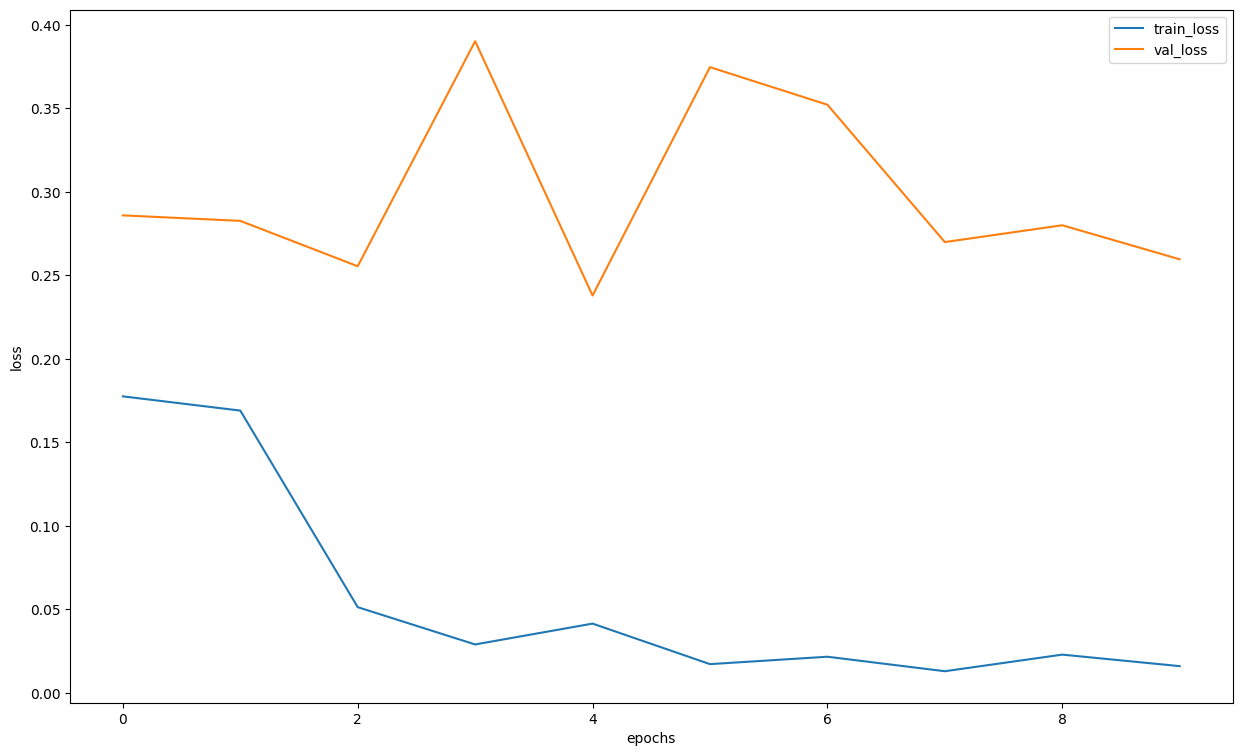

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = F.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(currrent_model, imgs)

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 1.0


In [ ]:
class TestDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __getitem__(self, index):
        test_transforms = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
        ])
        img = Image.open(self.files[index]).convert('RGB')
        return test_transforms(img)

    def __len__(self):
        return len(self.files)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(currrent_model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
my_submit = pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
})
my_submit.to_csv("/content/gdrive/MyDrive/simpsons_m3_submission.csv", index=False)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
if torch.cuda.is_available():
  # Clear GPU memory
  torch.cuda.empty_cache()
